# Spread of an infectious disease: SEIR model analysis with Emukit

This notebook uses the SEIR-model and Emukit to answer several application driven research questions.

## Overview

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

# Figure config
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
LEGEND_SIZE = 15
TITLE_SIZE = 25
AXIS_SIZE = 15
FIGURE_SIZE = (12, 8)

# for reproducibility
np.random.seed(42)

## The SEIR epidemic model

The [SEIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model) is a compartmental model of biology that simulates the spread of an infectious disease. 
A population of $N$ individuals is divided into the compartments: **S**: susceptible, **E**: exposed, **I**: infected, **R**: recovered with $N = N_S + N_E + N_I + N_R$.

The individuals in compartment **S** (susceptible) can contract an infection and transition to compartment **E** (exposed). 
The compartment 'exposed' is introduced to model incubation times; exposed objects are already infected, but are not infectious themselves yet. Once they become infectious they transition to compartment **I** (infected) and can infect susceptible individuals in **S** (susceptible). 
Once the disease is over the individuals in **I** (infected) transition to **R** (recovered) and becomes immune to the infection. 

In this notebook we are going to use a simulation of the SEIR model in order to answer a few questions about behavior of the SEIR model, defined as [Tasks](#tasks) below. 
For that we need to be able to evaluate the SEIR model for a given set of inputs. For that we are going to use *Gillespie* algorithm which draws exact samples from the SEIR model.

#### The Gillespie simulation
The dynamics of the SEIR model are determined by stochastic discrete-time events of individuals changing infection state, for which Poisson processes (i.e., exponentially distributed inter-event times) are commonly assumed. 
The [Gillespie algorithm](https://en.wikipedia.org/wiki/Gillespie_algorithm) draws correct sample-trajectories from the simulation, hence, to query the SEIR model, many runs are required which can then be averaged to construct an estimator. 

The rate of infection and the rate of recovery are denoted as constants $a$ and $b$ respectively. The incubation time is $c^{-1}$.
To simplify matters in this illustrative notebook, we consider the case that we know the rate of recovery $b$ once an individual has been infected and the incubation time $c^{-1}$, but that we are uncertain about the infection rate $a$. We also assume that we know the initial state of the simulation which is one infected individual only and no recovered or exposed individuals. This means all remaining individuals are susceptible.

For a given infection rate $a$, the Gillespie simulation draws many (1000s) of Gillespie repetitions of the SEIR model and returns for example the time or location of the maximum of each sample (see [Tasks](#tasks) below). The expected value of the relevant quantity is computed by averaging over these samples. The many repetitions of the simulation is what makes it expensive.

**Note on notation:** To simplify notation we normalize with respect to population size $x_i = \frac{N_I}{N}$ for $i \in \{S, I, E, R\}$ and express time in units of recovery time $b^{-1}$, $t \rightarrow b t$. Furthermore, we call $\alpha:=\frac{a}{b}$ and $\beta := \frac{c}{b}$. Thus $\alpha$ is the ratio of infection and recovery rate (or time) and $\beta$ the ratio of incubation rate and recovery rate (or time).

<a id='tasks'></a>
# Tasks

The three Tasks below illustrate practical questions that can be answered by combing the SEIR model with the inference methods in Emukit. 
The answers to these tasks might lead to practical decisions such as how much and when to order vaccines, or labor plans for hospital capacity.
From the point of Emukit, the SEIR model identifies several Emukit user-functions which we define below. 


**A side note on wording:** Note that we cannot answer the Tasks precisely since the SEIR model is inherently a stochastic simulation, meaning that each query of the Gillespie simulation which averages over many runs is already an expectation itself. This means that e.g., for an unknown infection rate we are concerned with an expectation of an expectation. To simplify wording we will ignore the first expectation and will call e.g., the 'expected height of peak for a given infection rate with respect to the Gillespie distribution' simply the 'height of the peak' and use 'expectation' only for the expected values with respect to the distribution of the unknown infection rate $a$. The results have to be interpreted accordingly.

### 1. How many individuals will maximally be infected simultaneously (height of peak)?

Since the infection rate $a$ is unknown, we can not answer this question precisely
But we can compute an estimator, i.e., the expected maximum number of individuals which are infected at the same time $\mathbb{E}_a\left[\max_t N_I(t, \alpha)\right]$. This involves solving an integral numerically. Assuming running the Gillespie simulation is expensive, we will use the [Bayesian quadrature](Emukit-tutorial-Bayesian-quadrature-introduction.ipynb) component of Emukit since Bayesian quadrature is particularly well suited for low-dimensional expensive integrals. Bayesian quadrature also naturally returns an uncertainty estimate of the integral value that can be used to assess if we need to run further Gillespie simulations.

### 2. When will the infection be at its peak (time-occurrence of peak)?

This problem is similar to the one above, but this time we are interested in when in time the peak of infections occurs, i.e., $\mathbb{E}_a\left[\mathrm{arg}\,\mathrm{max}_t N_I(t, \alpha)\right]$. Again we can use the Bayesian quadrature component of Emukit since we need to solve an integral. The difference to Task 1 is that now the Bayesian quadrature algorithm collects the most informative Gillespie runs that correspond to estimating $\mathbb{E}_a\left[\mathrm{arg}\,\mathrm{max}_t N_I(t, \alpha)\right]$ rather than $\mathbb{E}_a\left[\max_t N_I(t, \alpha)\right]$. 

### 3. How does the height of the peak relate to the infection rate?

Apart from knowing how high the peak of infection will be and when it will occur, we might want to know how these estimates change with infection rate, hence we might want to build an emulator which is learned by the [experimental design]() package in Emukit. We can query or use this emulator if we want to predict the height of the peak for a new infection rate at a later time at which we cannot run a Gillespie simulation for whatever reason. We might for example learn at a later point that the infection rate is indeed 5.7 time units but we have not enough time to run the Gillespie simulation again for this value. The experimental design emulator not only predicts the peak height but also an uncertainty estimate of the prediction which we can base our decision on. Again, the difference to Tasks 1 and 2 is that now the Gillespie model will be queried with infection rates which leads the emulator to learn the relation to the height of the peak efficiently.

### 4. Beyond this notebook 
There can be many more questions asked. With a [multi-fidelity model](Emukit-tutorial-multi-fidelity.ipynb) one can relate the high-fidelity Gillespie results to cheaper but approximate simulations. Such an approximate model is called a low-fidelity model. An example of a low-fidelity SEIR model is a system of ordinary differential equations (ODEs) that describe the average dynamics of the spread of the disease in the thermodynamic limit of a very large population size $N$. 
The ODE system, listed here for completeness, does, however, not admit a generic analytic solution. 

\begin{equation}
\begin{aligned}
\frac{d\,x_S}{d\,t} &= -\alpha x_I x_S,\quad
\frac{d\,x_E}{d\,t} = a x_I x_S - \beta x_E,\quad
\frac{d\,x_I}{d\,t} = \beta x_E  - \,x_I,\quad
\frac{d\,x_R}{d\,t} = x_I.
\end{aligned}
\end{equation}

Solving the ODE can be seen as querying a low-fidelity model of the high-fidelity Gillespie simulation which is less precise but therefore much faster. Another even coarse low-fidelity model might be a simplified version in which e.g., the effect of the incubation time is neglected.

If our disease model also included the effect of e.g., vaccines or treatment in a certain area (the SEIR model presented here does not), with [Bayesian optimization](Emukit-tutorial-Bayesian-optimization-introduction.ipynb) we could find the optimal allocation of medical personal in a region.

The emulator usually also provides gradients of the learned relation (e.g., between infection rate and expected height of peak) which can be used for model-based [sensitivity analysis](Emukit-tutorial-sensitivity-montecarlo.ipynb). 

In this notebook we will attempt to answer Tasks 1, 2 and 3.

### Navigation

1. [Task 1: Height of peak of infection](#section-task1)

2. [Task 2: Time-occurrence of peak of infection](#section-task2)

3. [Task 3: Infection rate and peak height relation](#section-task3)

4. [Discussion and conclusion](#conclusion)

## Load Emukit packages

We use the Emukit  quadrature package for Tasks 1 and 2, and the Emukit experimental design package for Task 3. For common functionality we use Emukit core. For the emulator model we use GPy since GPy model wrappers already exist in Emukit.

In [2]:
# SEIR model and Gillespie simulation
import Emukit_task_seir_model as seir

# GPy for the model
import GPy

# Emukit model wrapper
from emukit.model_wrappers.gpy_quadrature_wrappers import RBFGPy, BaseGaussianProcessGPy
from emukit.model_wrappers import GPyModelWrapper

# Emukit core
from emukit.core import ParameterSpace, ContinuousParameter

# Emukit quadrature
from emukit.quadrature.measures import LebesgueMeasure
from emukit.quadrature.kernels import QuadratureRBFLebesgueMeasure
from emukit.quadrature.methods import VanillaBayesianQuadrature
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop

# Emukit experimental design
from emukit.experimental_design import ExperimentalDesignLoop

## Load SEIR model

We fix the incubation rate to $\beta = 4$, i.e. recovery takes 4 times longer than incubation. This will usually result in a simulated breakout of the disease.


In [3]:
population_size = 100 # size of population N
alpha_init = 10. # infection rate/recovery rate
beta = 4. # incubation rate/recovery rate

t_end = 10. # end time of simulation
t_eval = np.linspace(0., t_end, 200) # fixed time steps for simulation
num_gil = 1000 # number of gillespie runs, 1000 will give roughly noisfree observations

In [4]:
# Set up the gillespie model
seir_model = seir.SEIR(population_size, alpha_init, beta)
seir_gil = seir.SEIRGillespie(seir_model)

# Prior over alpha. This prior will be integrated against in Task 1 and 2
alpha_prior = seir.GammaPrior(5., 1., 5.)

# computes expected time occurance and height of the infection peak for a given alpha. 
meanmax = seir.MeanMaxInfectionGillespie(seir_gil, num_gil, t_end, alpha_prior)

<a id='section-task1'></a>
## Task 1: Height of peak of infection

The height of the peak is the expected maximal number of simultaneously infected individuals 

$$
\mathbb{E}_a\left[\max_t N_I(t, \alpha)\right] =\int_{\Omega}\max_t N_I(t, \alpha)p(\alpha)\mathrm{d}\alpha.
$$

We use the Bayesian quadrature package of Emukit to emulate the integrand $\max_tN_I(t, \alpha)p(\alpha)$. 

#### Define user function $\max_t N_I(t, \alpha)p(\alpha)$ and integral bounds 

We call the integrand $\max_t N_I(t, \alpha)p(\alpha)$ `f_height_of_peak_weighted`  since it computes the height of the infection peak weighted with the prior on $\alpha$. One call of `f_height_of_peak_weighted` will run `num_gil` Gillespie runs. The integral bounds have units $\alpha$, i.e., units of infection time divided by recovery time; they define the domain $\Omega = [lower\_bounds, upper\_bound]$. We choose `80` to be the upper bound since we assume that the infection rate will not be larger than 80 times the recovery rate.


In [5]:
# define the integrand 
f_height_of_peak_weighted = seir.height_of_peak_weighted(meanmax)

# define integral bounds
lb = 1. # lower integral bound
ub = 80. # upper integral bound

#### Get initial observations


The quadrature model needs a few random starting locations to get an initial calibration of its hyperparameters.

In [6]:
# number of initial points
N_init_task1 = 3

# inital traning points: locations X_init sampled uniformly from [lower_bound, upper_bound]. 
X_init_task1 = np.random.rand(N_init_task1, 1)*(ub-lb) + lb 
Y_init_task1 = f_height_of_peak_weighted(X_init_task1)

#### Create Emukit surrogate model (the emulator) for the integrand function

We use the GPy package to build the model and the GPy model wrapper which is already in Emukit. Then we choose the vanilla Bayesian quadrature method and create the loop. We then run the loop for a certain number of iterations. Finally we integrate the model and collect the estimated expectation of the height of the infection peak and its variance.

In [7]:
# make your GP model in GPy.
gpy_model_task1 = GPy.models.GPRegression(X=X_init_task1, Y=Y_init_task1, 
                        kernel=GPy.kern.RBF(input_dim=X_init_task1.shape[1], 
                                            lengthscale=10.0, variance=1.0))

# create emukit quadrature GP model
emukit_measure = LebesgueMeasure.from_bounds([(lb, ub)])
emukit_qrbf = QuadratureRBFLebesgueMeasure(rbf_kernel=RBFGPy(gpy_model_task1.kern), 
                                           measure=emukit_measure)
emukit_model = BaseGaussianProcessGPy(kern=emukit_qrbf, gpy_model=gpy_model_task1) 

In [8]:
# choose vanilla Bayesian quadrature method and make loop
emukit_method = VanillaBayesianQuadrature(base_gp=emukit_model, X=X_init_task1, Y=Y_init_task1)
emukit_loop = VanillaBayesianQuadratureLoop(model=emukit_method)

In [9]:
# run the loop for a number of iterations and collect result
num_iter = 5
emukit_loop.run_loop(user_function=f_height_of_peak_weighted, stopping_condition=num_iter)
height_of_peak_estimate, height_of_peak_variance = emukit_loop.model.integrate()

#### Print and plot result

We plot the integrand, i.e, the weighted height of the infection peak vs $\alpha$ (the ratio of infection rate and recovery rate). We also plot the distribution of the expected height of the infection peak which represents our (un-)certainty over its value. 

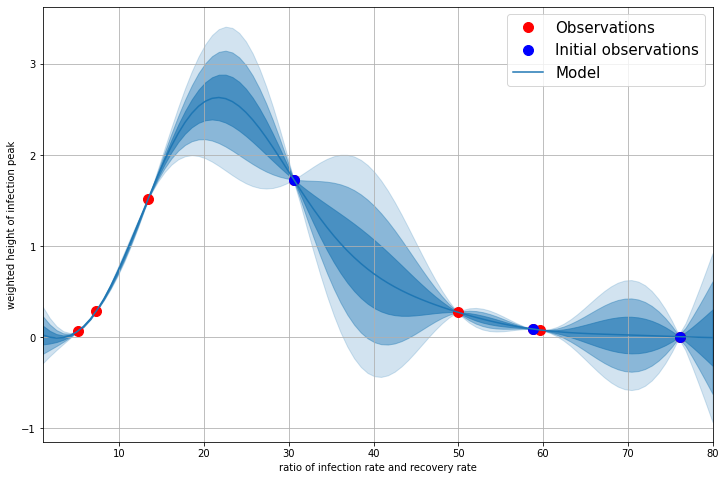

In [10]:
x_plot = np.linspace(lb, ub, 100)[:, None]
mu_plot, var_plot = emukit_loop.model.predict(x_plot)

X_plot = emukit_loop.loop_state.X
Y_plot = emukit_loop.loop_state.Y

plt.figure(figsize=FIGURE_SIZE)
plt.plot(X_plot, Y_plot, "ro", markersize=10, label="Observations")
plt.plot(X_init_task1, Y_init_task1, "bo", markersize=10, label="Initial observations")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=1, prop={'size': LEGEND_SIZE})
plt.xlabel(r"ratio of infection rate and recovery rate")
plt.ylabel(r"weighted height of infection peak")
plt.grid(True)
plt.xlim(lb, ub)
plt.show()

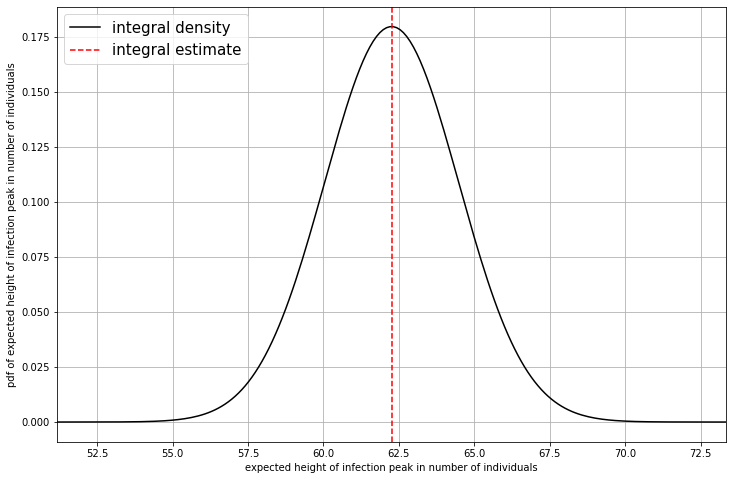

In [11]:
initial_integral_mean = height_of_peak_estimate
initial_integral_variance = height_of_peak_variance

x_plot_integral = np.linspace(initial_integral_mean-5*np.sqrt(initial_integral_variance), 
                              initial_integral_mean+5*np.sqrt(initial_integral_variance), 200)
y_plot_integral_initial = 1/np.sqrt(initial_integral_variance * 2 * np.pi) * \
np.exp( - (x_plot_integral - initial_integral_mean)**2 / (2 * initial_integral_variance) )
plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot_integral, y_plot_integral_initial, "k", label="integral density")
plt.axvline(initial_integral_mean, color="red", label="integral estimate", \
            linestyle="--")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"expected height of infection peak in number of individuals")
plt.ylabel(r"pdf of expected height of infection peak in number of individuals")
plt.grid(True)
plt.xlim(np.min(x_plot_integral), np.max(x_plot_integral))
plt.show()

In [12]:
print('=== TASK 1: Result ===')
print()
print('The estimated expected height of the infection peak is: ', round(height_of_peak_estimate), 'individuals,')
print('with a credible interval: ', int(np.ceil(2*np.sqrt(height_of_peak_variance))), 'individuals.')

=== TASK 1: Result ===

The estimated expected height of the infection peak is:  62 individuals,
with a credible interval:  5 individuals.


<a id='section-task2'></a>
## Task 2: Time-occurrence of peak of infection


The time of the peak is the expected time-occurrence when the number of simultaneously infected individuals is maximal.

$$
\mathbb{E}_a\left[\mathrm{arg}\,\mathrm{max}_t N_I(t, \alpha)\right] =\int_{\Omega}\mathrm{arg}\,\mathrm{max}_t N_I(t, \alpha)p(\alpha)\mathrm{d}\alpha.
$$

We use the Bayesian quadrature package of Emukit to emulate the integrand $\mathrm{arg}\,\mathrm{max}_tN_I(t, \alpha)p(\alpha)$. 

#### Define user function $\mathrm{arg}\,\mathrm{max}_t N_I(t, \alpha)p(\alpha)$ and integral bounds 

We call the integrand $\mathrm{arg}\,\mathrm{max}_t N_I(t, \alpha)p(\alpha)$ `f_time_of_peak_weighted`  since it computes the time occurrence of the infection peak weighted with the prior on $\alpha$. One call of `f_time_of_peak_weighted` will run `num_gil` Gillespie runs. The integral bounds are the same as in Task 1.


In [13]:
# define the integrand 
f_time_of_peak_weighted = seir.time_of_peak_weighted(meanmax)

In [14]:
# number of initial points
N_init_task2 = 3 

# inital traning points: locations X_init sampled uniformly from [lower_bound, upper_bound]. 
X_init_task2 = np.random.rand(N_init_task2, 1)*(ub-lb) + lb 
Y_init_task2 = f_time_of_peak_weighted(X_init_task2)

In [15]:
# make your GP model in GPy.
gpy_model_task2 = GPy.models.GPRegression(X=X_init_task2, Y=Y_init_task2, 
                        kernel=GPy.kern.RBF(input_dim=X_init_task2.shape[1], 
                                            lengthscale=10.0, variance=1.0))
# create emukit quadrature GP model
emukit_measure = LebesgueMeasure.from_bounds([(lb, ub)])
emukit_qrbf = QuadratureRBFLebesgueMeasure(rbf_kernel=RBFGPy(gpy_model_task2.kern), 
                                           measure=emukit_measure)
emukit_model = BaseGaussianProcessGPy(kern=emukit_qrbf, gpy_model=gpy_model_task2) 

In [16]:
# choose vanilla Bayesian quadrature method and make loop
emukit_method = VanillaBayesianQuadrature(base_gp=emukit_model, X=X_init_task2, Y=Y_init_task2)
emukit_loop = VanillaBayesianQuadratureLoop(model=emukit_method)

In [17]:
# run the loop for a number of iterations and collect result
num_iter = 5
emukit_loop.run_loop(user_function=f_time_of_peak_weighted, stopping_condition=num_iter)
time_of_peak_estimate, time_of_peak_variance = emukit_loop.model.integrate()

#### Print and plot result

We plot the integrand, i.e, the time of the infection peak vs $\alpha$ (the ratio of infection rate and recovery rate). We also plot the distribution of the expected time of the infection peak which represent our (un-)certainty over its value. 

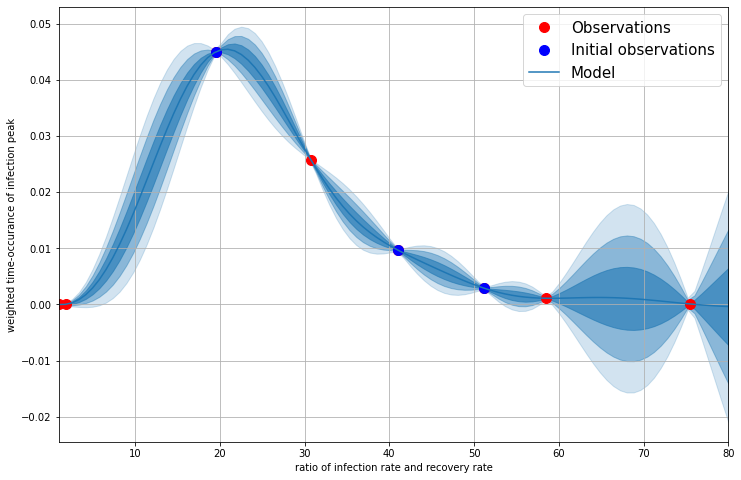

In [18]:
x_plot = np.linspace(lb, ub, 100)[:, None]
mu_plot, var_plot = emukit_loop.model.predict(x_plot)

X_plot = emukit_loop.loop_state.X
Y_plot = emukit_loop.loop_state.Y

plt.figure(figsize=(12, 8))
plt.plot(X_plot, Y_plot, "ro", markersize=10, label="Observations")
plt.plot(X_init_task2, Y_init_task2, "bo", markersize=10, label="Initial observations")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=1, prop={'size': LEGEND_SIZE})
plt.xlabel(r"ratio of infection rate and recovery rate")
plt.ylabel(r"weighted time-occurance of infection peak")
plt.grid(True)
plt.xlim(lb, ub)
plt.show()

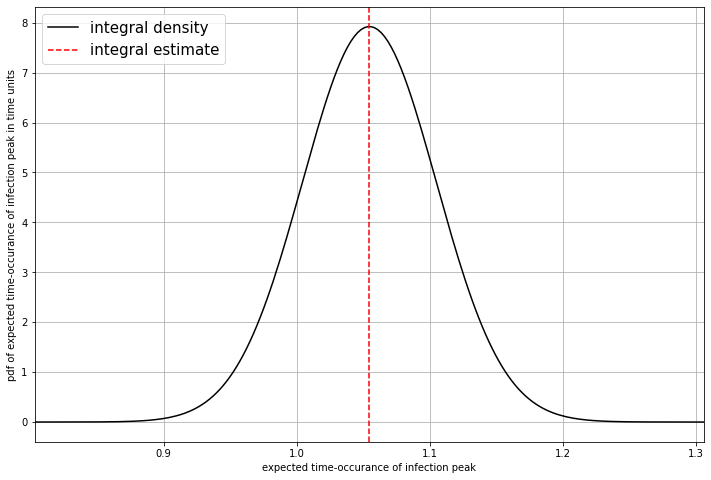

In [19]:
initial_integral_mean = time_of_peak_estimate
initial_integral_variance = time_of_peak_variance

x_plot_integral = np.linspace(initial_integral_mean-5*np.sqrt(initial_integral_variance), 
                              initial_integral_mean+5*np.sqrt(initial_integral_variance), 200)
y_plot_integral_initial = 1/np.sqrt(initial_integral_variance * 2 * np.pi) * \
np.exp( - (x_plot_integral - initial_integral_mean)**2 / (2 * initial_integral_variance) )
plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot_integral, y_plot_integral_initial, "k", label="integral density")
plt.axvline(initial_integral_mean, color="red", label="integral estimate", \
            linestyle="--")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"expected time-occurance of infection peak")
plt.ylabel(r"pdf of expected time-occurance of infection peak in time units")
plt.grid(True)
plt.xlim(np.min(x_plot_integral), np.max(x_plot_integral))
plt.show()

In [20]:
print('=== TASK 2: Result ===')
print()
print('The estimated expected time of the infection peak is: ', round(time_of_peak_estimate, 2), 'time units.')
print('with a credible interval: ', round(2*np.sqrt(time_of_peak_variance), 2), 'time units.')

=== TASK 2: Result ===

The estimated expected time of the infection peak is:  1.05 time units.
with a credible interval:  0.1 time units.


<a id='section-task3'></a>
## Task 3: Infection rate and peak-height relation

We want to predict how the height of the infection peak varies with the infection rate, even if we did not perform Gillespie runs for a particular $\alpha$. For this we use the experimental design package of Emukit and model the relation between infection rate and peak height explicitly with a Gaussian process. 

#### Define user function $\max_t N_I(t, \alpha)$ 

We call the relation $\max_t N_I(t, \alpha)p(\alpha)$ `f_height_of_peak`  since it computes the height of the infection, this time unweighted. One call of `f_height_of_peak` will run `num_gil` Gillespie runs. 

In [21]:
# define the user function
f_height_of_peak = seir.height_of_peak(meanmax)

# this is the infection rate ratio we are intereted in at a later point. We can define it here 
# already since this is a tutorial. It will not be used by Emukit to train the model.
alpha_unobserved = np.array([[5.]])

In [22]:
# number of initial points
N_init_task3 = 3 

# inital traning points: locations X_init sampled uniformly from [lower_bound, upper_bound]. 
X_init_task3 = np.random.rand(N_init_task3, 1)*(ub-lb) + lb 
Y_init_task3 = f_height_of_peak(X_init_task3)

In [23]:
# make your GP model in GPy.
gpy_model_task3 = GPy.models.GPRegression(X=X_init_task3, Y=Y_init_task3, 
                        kernel=GPy.kern.RBF(input_dim=X_init_task1.shape[1], 
                                            lengthscale=10.0, variance=1.0))
gpy_model_task3.Gaussian_noise.constrain_fixed(1.e-10)

# create emukit GP model
model_emukit = GPyModelWrapper(gpy_model=gpy_model_task3)

In [24]:
# Create the parameters space
parameter_space_emukit = ParameterSpace([ContinuousParameter('alpha', lb, ub)])

In [25]:
# Create the experimental design object
loop_emukit = ExperimentalDesignLoop(space=parameter_space_emukit, model=model_emukit) 

In [26]:
# run the loop for a number of iterations and collect predictions
num_iter = 5
loop_emukit.run_loop(user_function=f_height_of_peak, stopping_condition=num_iter)
predicted_height_of_peak_mean, predicted_height_of_peak_variance \
                                            = loop_emukit.model.predict(alpha_unobserved)

 /home/mmahsereci/.local/lib/python3.9/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


#### Print and plot result

We plot the emulator which models the relation between the height of the infection peak and $\alpha$ (the ratio of infection rate and recovery rate). We see that we can make predictions at points where we did not run the Gillesspie algorithms. The emulator also returns and uncertainty estimate for its prediction at that location.

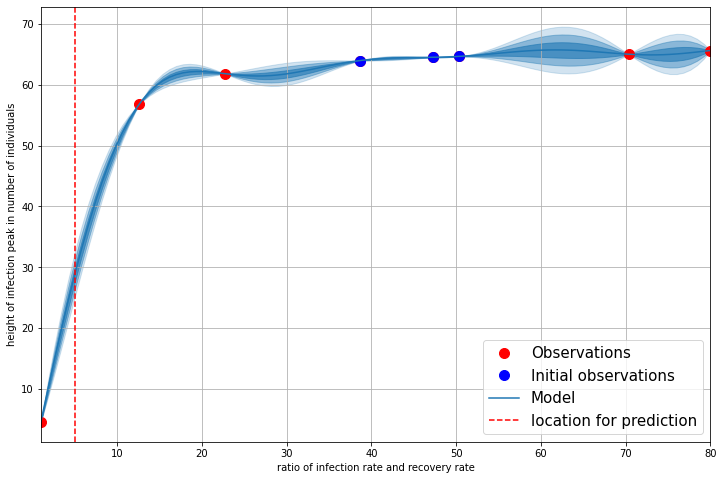

In [27]:
x_plot = np.linspace(lb, ub, 100)[:, None]
mu_plot, var_plot = loop_emukit.model.predict(x_plot)

X_plot = loop_emukit.loop_state.X
Y_plot = loop_emukit.loop_state.Y

plt.figure(figsize=FIGURE_SIZE)
plt.plot(X_plot, Y_plot, "ro", markersize=10, label="Observations")
plt.plot(X_init_task3, Y_init_task3, "bo", markersize=10, label="Initial observations")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.axvline(alpha_unobserved[0, 0], color="red", label="location for prediction", \
            linestyle="--")
plt.legend(loc=4, prop={'size': LEGEND_SIZE})
plt.xlabel(r"ratio of infection rate and recovery rate")
plt.ylabel(r"height of infection peak in number of individuals")
plt.grid(True)
plt.xlim(lb, ub)
plt.show()

In [28]:
print()
print('=== TASK 3 Result ===')
print('The estimated height of the infection peak at the unobserved gillespie run with alpha =', 
      round(alpha_unobserved[0, 0]),' is: ', int(round(predicted_height_of_peak_mean[0, 0])), 
      'individuals, with a credible interval: ', int(np.ceil(2*np.sqrt(predicted_height_of_peak_variance[0, 0]))), 'individuals.')



=== TASK 3 Result ===
The estimated height of the infection peak at the unobserved gillespie run with alpha = 5  is:  29 individuals, with a credible interval:  3 individuals.


<a id='conclusion'></a>
## Discussion and conclusion 

We solved all three tasks by only running a small number of simulations each. In comparison, for example, computing the ground truth integrals of Tasks 1 and 2 requires approximately one hour on a laptop even though the integration problems are only one-dimensional. This notebook runs in just a few minutes.

We also observe that the GP models assign a certain probability to negative values of quantities which we know to be positive, e.g., the number of individuals which are infected. Thus more elaborate models compatible with Emukit such as warped GPs might be even more suitable to the tasks presented here. Still, all methods used here yield a reliable answers for all our three tasks which are:

In [29]:
print('=== TASK 1 ===')
print('The estimated expected height of the infection peak is: ', round(height_of_peak_estimate), 'individuals,')
print('with a credible interval: ', np.ceil(2*np.sqrt(height_of_peak_variance)), 'individuals.')

print()
print('=== TASK 2 ===')
print('The estimated expected time of the infection peak is: ', round(time_of_peak_estimate, 2), 'time units.')
print('with a credible interval: ', round(2*np.sqrt(time_of_peak_variance), 2), 'time units.')

print()
print('=== TASK 3 ===')
print('The estimated height of the infection peak at the unobserved gillespie run with alpha =', 
      round(alpha_unobserved[0, 0]),' is: ', int(round(predicted_height_of_peak_mean[0, 0])), 
      'individuals, with a credible interval: ', int(np.ceil(2*np.sqrt(predicted_height_of_peak_variance[0, 0]))), 'individuals.')


=== TASK 1 ===
The estimated expected height of the infection peak is:  62 individuals,
with a credible interval:  5.0 individuals.

=== TASK 2 ===
The estimated expected time of the infection peak is:  1.05 time units.
with a credible interval:  0.1 time units.

=== TASK 3 ===
The estimated height of the infection peak at the unobserved gillespie run with alpha = 5  is:  29 individuals, with a credible interval:  3 individuals.
